In [1]:
import numpy as np
import pandas as pd
import os
import time
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
# from autogluon.tabular import TabularDataset,TabularPredictor

D:\Anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
pd.set_option('display.max_columns', None) #显示所有列
# pd.set_option('display.max_row', None) #显示所有行

In [3]:
os.chdir("train") #更改路径

### 1、数据分析

### 1.1 base_info（企业基本信息）

#### 1.1.1 字段解释

In [4]:
# id:企业唯一标识, 
# oplocdistrict:行政区划代码,
# industryphy:行业类别代码, 
# industryco:行业细类代码, 
# dom:经营地址, opscope:经营范围, 
# enttype:企业类型, 
# enttypeitem:企业类型小类, 
# opfrom:经营期限起, 
# opto:经营期限止, 
# state:状态, 
# orgid:机构标识, 
# jobid:职位标识, 
# adbusign:是否广告经营,
# townsign:是否城镇, 
# regtype:主题登记类型, 
# empnum:从业人数, 
# compform:组织形式,
# parnum:合伙人数, 
# exenum:执行人数, 
# opform:经营方式, 
# ptbusscope:经营范围, 
# venind:风险行业, 
# enttypeminu:企业类型细类, 
# midpreindcode:中西部优势产业代码,
# protype:项目类型, 
# oploc:经营场所,
# regcap:注册资本（金）,
# reccap:实缴资本, 
# forreccap:实缴资本（外方）,
# forregcap:注册资本（外方）,
# congro:投资总额, 
# enttypegb:企业（机构）类型

base_info=pd.read_csv("base_info.csv")

#### 1.1.2 数据预处理

In [5]:
miss_base_info=base_info.isnull().sum().sort_values(ascending=False).reset_index()
miss_base_info.columns=['var','miss_num']
miss_base_info['miss_pct']=miss_base_info['miss_num']/base_info.shape[0]
# miss_base_info

In [6]:
# 剔除缺失值占比过高的变量
drop_var=list(miss_base_info['var'][:14])
drop_var.append('opscope')

# 变量opscope可后续做研究
base_result=base_info.drop(columns=drop_var)

### 1.2 annual_report_info （企业年报基本信息）

#### 1.2.1 字段解释

In [7]:
# - - - - - - - - - -字段解释- - - - - - - - - -
# id:企业唯一标识, 
# ancheyear:年度, 
# state:状态, 
# fundam:资金数额, 
# memnum:成员人数, 
# farnum:农民人数, 
# annnewmemnum:本年度新增成员人数, 
# annredmemnum:本年度退出成员人数, 
# empnum:从业人数,
# empnumsign:从业人数是否公示,
# busstname:经营状态名称, 
# colgranum:其中高校毕业生人数经营者,
# retsolnum:其中退役士兵人数经营者, 
# dispernum:其中残疾人人数经营者,
# unenum:其中下岗失业人数经营者, 
# colemplnum:其中高校毕业生人数雇员, 
# retemplnum:其中退役士兵人数雇员, 
# disemplnum:其中残疾人人数雇员, 
# uneemplnum:其中下岗失业人数雇员,
# websitsign:是否有网站标志, 
# forinvestsign:是否有对外投资企业标志, 
# stocktransign:有限责任公司本年度是否发生股东股权转让标志,
# pubstate:公示状态：1 全部公示，2部分公示,3全部不公示

annual_report_info=pd.read_csv("annual_report_info.csv")

In [8]:
# 变量名全转换成小写状态
columns=[]
for i in annual_report_info.columns:
    columns.append(i.lower())
annual_report_info.columns=columns

#### 1.2.2 数据预处理

In [9]:
miss_annual_report=annual_report_info.isnull().sum().sort_values(ascending=False).reset_index()
miss_annual_report.columns=['var','miss_num']
miss_annual_report['miss_pct']=miss_annual_report['miss_num']/annual_report_info.shape[0]
# miss_annual_report

In [10]:
# annual_report.describe().T

In [11]:
# 取最近的企业基本年报信息
annual_report=annual_report_info.iloc[annual_report_info.groupby('id')['ancheyear'].idxmax(),:].reset_index(drop=True)

### 1.3 tax_info（企业纳税信息）

#### 1.3.1 字段解释

In [12]:
# id:企业唯一标识, start_date:起始时间, 
# end_date:终止时间, 
# tax_categories:税种, 
# tax_items:税目, 
# taxation_basis:计税依据,
# tax_rate:税率, 
# deduction:扣除数, 
# tax_amount:税额


tax_info=pd.read_csv("tax_info.csv")


columns=[]
for i in tax_info.columns:
    columns.append(i.lower())
tax_info.columns=columns

#### 1.3.2 数据预处理

In [13]:
miss_tax=tax_info.isnull().sum().sort_values(ascending=False).reset_index()
miss_tax.columns=['var','miss_num']
miss_tax['miss_pct']=miss_tax['miss_num']/tax_info.shape[0]
# miss_tax

# 各个变量缺失比例较少，保留全变量

In [14]:
tax_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29195 entries, 0 to 29194
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              29195 non-null  object 
 1   start_date      29195 non-null  object 
 2   end_date        29195 non-null  object 
 3   tax_categories  29195 non-null  object 
 4   tax_items       29195 non-null  object 
 5   taxation_basis  25816 non-null  float64
 6   tax_rate        25816 non-null  float64
 7   deduction       24235 non-null  float64
 8   tax_amount      29195 non-null  float64
dtypes: float64(4), object(5)
memory usage: 2.0+ MB


In [15]:
# 缴税总金额
tax_result=tax_info.groupby('id')['tax_amount'].sum().reset_index()

In [16]:
tax_info['end_date']=pd.to_datetime(tax_info['end_date'])

In [17]:
# tax_info.loc[tax_info.groupby('id')['end_date'].idxmax(),['id','taxation_basis','tax_rate','deduction']]

### 1.4 change_info（企业变更信息）

#### 1.4.1 字段解释

In [18]:
# id:企业唯一标识,
# bgxmdm:变更信息代码,
# bgq:变更前,
# bgh:变更后,
# bgrq:变更日期

change_info=pd.read_csv("change_info.csv")

#### 1.4.2 数据预处理

In [19]:
miss_change=change_info.isnull().sum().sort_values(ascending=False).reset_index()
miss_change.columns=['var','miss_num']
miss_change['miss_pct']=miss_change['miss_num']/change_info.shape[0]
# miss_change
# 变量无缺失值

In [20]:
# 将变量bgrq改成日期格式
change_info['bgrq']=change_info.bgrq.astype('str')
change_info['date']=change_info['bgrq']
for j,i in enumerate(change_info['bgrq']):
    change_info['date'][j]=i[:4]+'-'+i[4:6]+'-'+i[6:8]
    
    
change_info['date']=pd.to_datetime(change_info['date'])

<ipython-input-20-9958420a2f95>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  change_info['date'][j]=i[:4]+'-'+i[4:6]+'-'+i[6:8]


In [21]:
# - - - - - - - - - -构造新变量- - - - - - - - - -
# 变更次数、变更间隔时长、最近一次变更距今时长



# 变更次数
change_result=pd.DataFrame(change_info.groupby('id')['bgxmdm'].count()).reset_index().rename(columns={'bgxmdm':'change_times'})


# 变更间隔时长
change_interval=change_info.groupby('id')['date'].max()-change_info.groupby('id')['date'].min()
change_result=pd.merge(change_result,change_interval,on='id',how='outer')
change_result['interval']=change_result['date'].astype('str').apply(lambda x:x[:-5]).astype('int32')/(change_result['change_times']-1)


# 最近一次变更距今时长
basetime=datetime.strptime('2020-10-15','%Y-%m-%d')
change_recently=(basetime-change_info.groupby('id')['date'].max()).reset_index().rename(columns={'date':'interval_recent'})
change_recently['interval_recent']=change_recently['interval_recent'].astype('str').apply(lambda x:x[:-5]).astype('int32')


change_result=pd.merge(change_result,change_recently,on='id')
change_result=change_result.drop(columns=['date'])

### 1.5 news_info（新闻舆情信息）

In [22]:
news_info=pd.read_csv("news_info.csv")

In [23]:
miss_news=news_info.isnull().sum().sort_values(ascending=False).reset_index()
miss_news.columns=['var','miss_num']
miss_news['miss_pct']=miss_news['miss_num']/news_info.shape[0]
# miss_news
# 变量无缺失值

In [24]:
# 各类舆情发生的次数、最后一次舆情的类型、最后一次舆情距今时长

In [25]:
neutral=news_info.query("positive_negtive=='中立'").groupby(['id'])['positive_negtive'].count().reset_index().rename(columns={'positive_negtive':'neutral_num'})
positive=news_info.query("positive_negtive=='积极'").groupby(['id'])['positive_negtive'].count().reset_index().rename(columns={'positive_negtive':'positive_num'})
negtive=news_info.query("positive_negtive=='消极'").groupby(['id'])['positive_negtive'].count().reset_index().rename(columns={'positive_negtive':'negtive_num'})

In [26]:
news_result=pd.merge(neutral,positive,on='id',how='outer')
news_result=pd.merge(news_result,negtive,on='id',how='outer')
news_result=news_result.fillna(0)
# public_date=news_info.groupby('id')['public_date'].max().reset_index()
# news_result=pd.merge(news_result,public_date,on='id',how='outer')


# news_result.loc[news_result['public_date'].str.contains('小时前'),'public_date']=news_result.loc[news_result['public_date'].str.contains('小时前'),'public_date'].replace('2020-10-14',inplace=True)
# news_result['public_date']=pd.to_datetime(news_result['public_date'])


# from  datetime import datetime
# basetime=datetime.strptime('2020-10-15','%Y-%m-%d')
# news_result['days_news']=(basetime-news_result['public_date']).astype('str').apply(lambda x:x[:-5])


# news_result['days_news'].fillna(-999)
# news_result['days_news'].replace('',-999,inplace=True)
# news_result['days_news']=news_result['days_news'].astype('int32')

# news_result=news_result[['id','neutral_num','positive_num','negtive_num','days_news']]


### 1.6 other_info（其他信息）

In [27]:
# id:企业唯一标识, 
# legal_judgment_num:裁判文书数量, 
# brand_num:注册商标数量, 
# patent_num:专利数量

In [28]:
other_info=pd.read_csv("other_info.csv")

In [29]:
other_result=other_info.groupby('id').sum().reset_index()

### 1.7 entprise_info（企业标签信息）

In [30]:
entprise_info=pd.read_csv("entprise_info.csv")

In [39]:
# 数据合并
info=pd.merge(entprise_info,base_result,on='id',how='left')
info=pd.merge(info,annual_report,on='id',how='left')
info=pd.merge(info,tax_result,on='id',how='left')
info=pd.merge(info,change_result,on='id',how='left')
info=pd.merge(info,news_result,on='id',how='left')

In [40]:
info_analysis=info.select_dtypes(exclude='object')

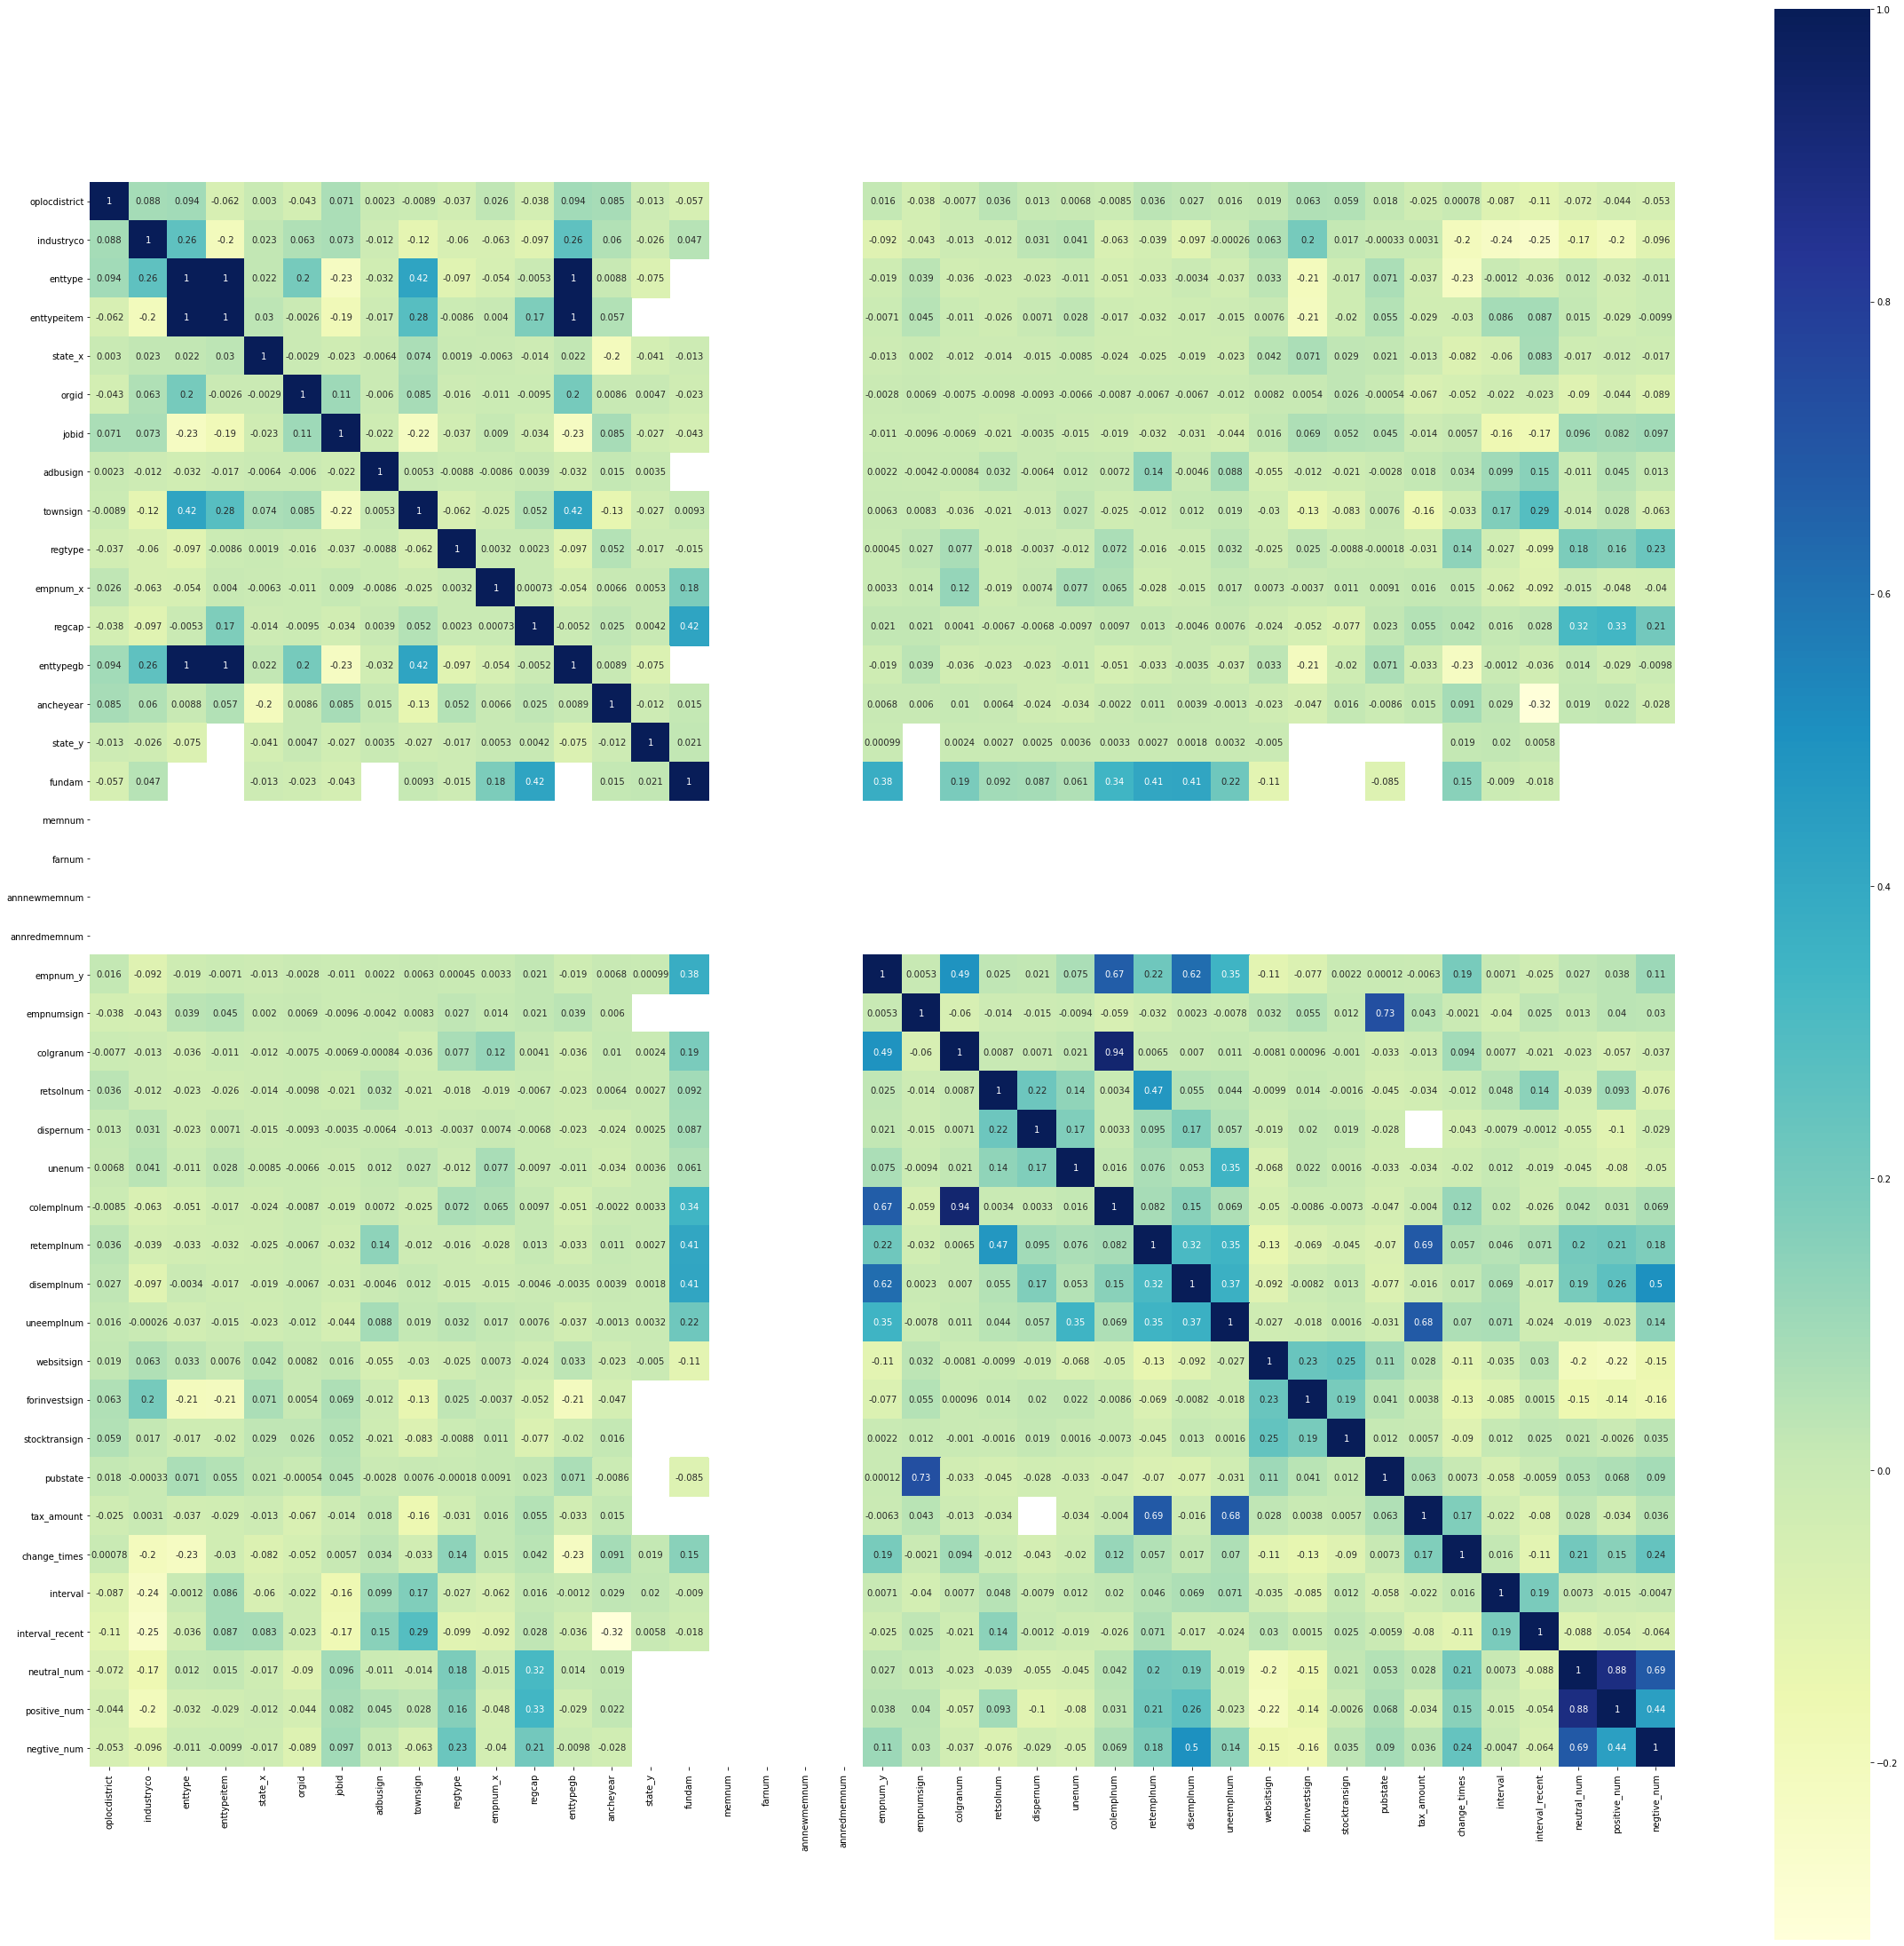

In [53]:
feature=info_analysis.columns[1:]
feature=list(feature)
corr=info_analysis[feature].corr()

plt.figure(figsize=(40,40))
sns.heatmap(corr,square=True,annot=True,cmap="YlGnBu")
plt.savefig("corr.png")